# Gaussian General Additive Regression (Cubic Basis) in PyTorch

Gaussian general additive regression uses a likelihood based on the Gaussian distribution.

The model that we'll fit is:

\begin{align*}
y_{i} &\sim \textrm{Normal}(\mu_{i}, \sigma^{2}) ~~~ \textrm{for}~ i=1, ..., N, \\
\mu_{i} &= \beta_{0} + B(x_{i}), 
\end{align*}

where 

* $y_{i}$ is the response of the $i\textrm{th}$ observation.
* $B(x_{i}) = \beta_{1}x_{i} + \beta_{2}x^{2}_{i} + \beta_{3}x^{3}_{i}$
* $x_{i}$ is the covariate values for the $i\textrm{th}$ observation.

The probability density function of the Gaussian distribution is:

\begin{align*}
f(y_{i}; \mu_{i}, \sigma) &= \frac{1}{\sigma\sqrt{2\pi}}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\mu_{i})^2 \right)
\end{align*}

Thus, the likelihood is 

\begin{align*}
L(\mu_{i}, \sigma; y_{i}) &= \prod_{i=1}^{N} \sigma^{-1} (2\pi)^{-0.5}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\mu_{i})^2 \right)
\end{align*}

The log-likelihood is 

\begin{align*}
\textrm{log}(L(\mu_{i}, \sigma; y_{i})) &= \sum_{i=1}^{N}\textrm{log} \left[ \sigma^{-1} (2\pi)^{-0.5}\exp\left( -\frac{1}{2\sigma^{2}} (y_{i}-\mu_{i})^2 \right) \right] \\
&= - \sum_{i=1}^{N}\left[ \textrm{log}(\sigma) + 0.5 \textrm{log}(2\pi) + \frac{1}{2\sigma^{2}} (y_{i}-\mu_{i})^2 \right]
\end{align*}

The negative log-likelihood is 

\begin{align*}
-\textrm{log}(L(\mu_{i}, \sigma; y_{i})) &= \sum_{i=1}^{N}\left[ \textrm{log}(\sigma) + 0.5 \textrm{log}(2\pi) + \frac{1}{2\sigma^{2}} (y_{i}-(\beta_{0} + B(x_{i})))^2 \right]
\end{align*}

## Import libraries

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from library.GAMGaussianRegression import GAMGaussianRegression

## Step 1: Generate synthetic data for the Beta regression

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

n = 1000
p = 1

# Generate a single predictor uniformly over [-10, 10]
x = (torch.rand(n, 1) * 10) - 5

# Define a cubic basis function: [1, x, x^2, x^3]
def cubic_basis(x):
    return torch.cat([torch.ones_like(x), x, x**2, x**3], dim=1)

# Set true parameters for the cubic basis: e.g. intercept=1.0, linear=2.0, quadratic=-1.0, cubic=0.5
true_beta = torch.tensor([[1.0], [5.0], [1.0], [-0.2]])
B = cubic_basis(x)
mu_true = B @ true_beta
true_sigma = 2

# Generate synthetic responses: y ~ N(mu_true, true_sigma^2)
y = mu_true + torch.randn(n, 1) * true_sigma

## Step 2: Plot the data

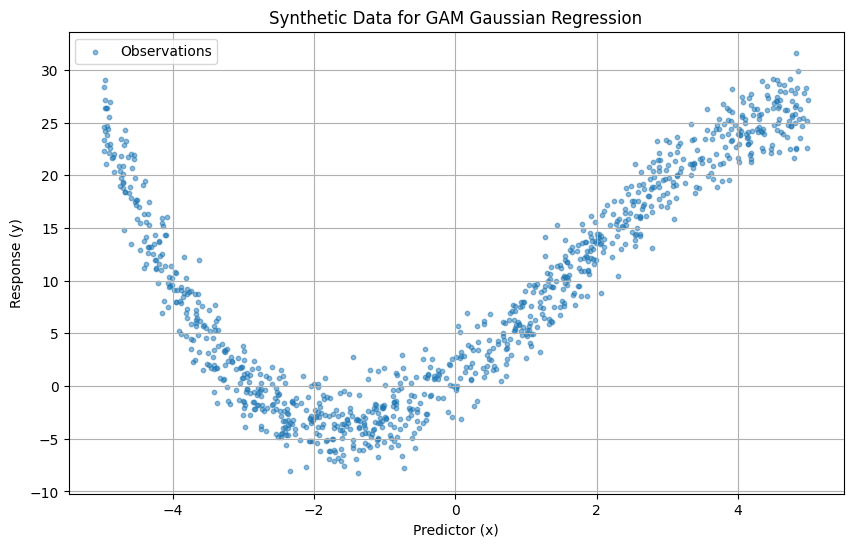

In [3]:
# Plot the response variable "y"
plt.figure(figsize=(10, 6))
plt.scatter(x.numpy(), y.numpy(), s=10, alpha=0.5, label='Observations')
plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.title('Synthetic Data for GAM Gaussian Regression')
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Instantiate model and optimizer

In [4]:
model = GAMGaussianRegression(x)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the model

In [5]:
num_epochs = 3000
losses = []
import time
start_time = time.time()  # Start timer

for epoch in range(num_epochs):
    loss = model.negative_log_likelihood(x, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], NLL: {loss.item():.4f}')

elapsed_time = time.time() - start_time  # Stop timer
print(f"Training completed in {elapsed_time:.2f} seconds")


Epoch [1000/3000], NLL: 2811.4812
Epoch [2000/3000], NLL: 2404.5208
Epoch [3000/3000], NLL: 2153.5347
Training completed in 1.86 seconds


# Step 5: Extract learned parameters

In [6]:
learned_beta = model.beta.data.flatten()
learned_sigma = model.sigma().item()

print("Learned parameters:")
print(f"β = {learned_beta.tolist()}")
print(f"σ = {learned_sigma:.4f}")
print("True parameters:")
print(f"β = {true_beta.flatten().tolist()}")
print(f"φ = {true_sigma:.4f}")


Learned parameters:
β = [0.8525990843772888, 4.762498378753662, 1.0079574584960938, -0.18650603294372559]
σ = 2.2550
True parameters:
β = [1.0, 5.0, 1.0, -0.20000000298023224]
φ = 2.0000


# Step 6: Plot results

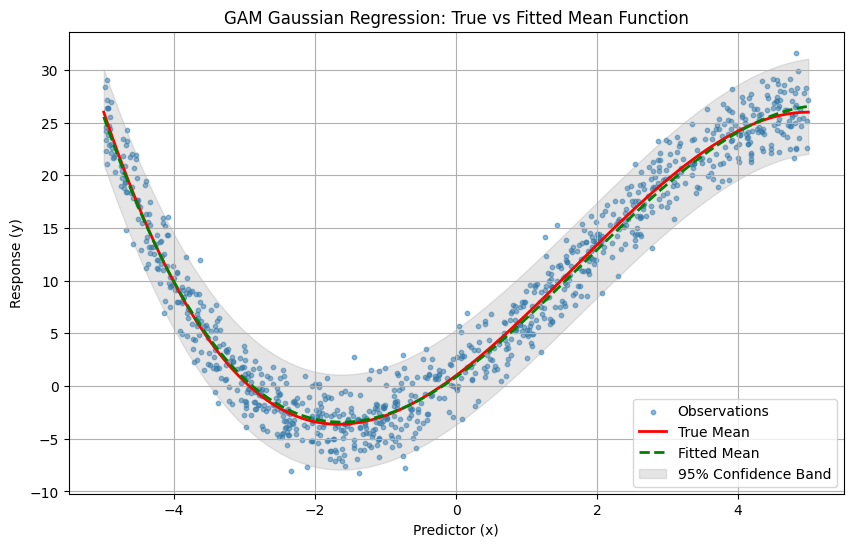

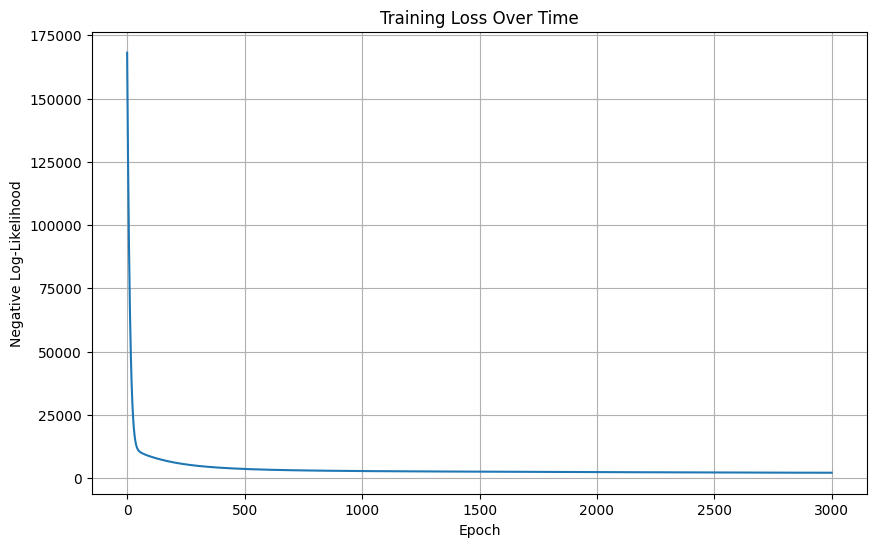

In [7]:
plt.figure(figsize=(10, 6))
    
# Create grid for plotting
x_range = torch.linspace(-5, 5, 100).reshape(-1, 1)
B_range = cubic_basis(x_range)

# Compute true mean function on grid
true_mu_range = B_range @ true_beta
# Compute fitted mean function on grid
fitted_mu_range = model(x_range).detach()

plt.scatter(x.numpy(), y.numpy(), s=10, alpha=0.5, label='Observations')
plt.plot(x_range.numpy(), true_mu_range.numpy(), 'r-', linewidth=2, label='True Mean')
plt.plot(x_range.numpy(), fitted_mu_range.numpy(), 'g--', linewidth=2, label='Fitted Mean')

# Compute confidence bands: fitted mean ± 2σ
upper_band = fitted_mu_range + 2 * learned_sigma
lower_band = fitted_mu_range - 2 * learned_sigma
plt.fill_between(x_range.flatten().numpy(), 
                    lower_band.flatten().numpy(), 
                    upper_band.flatten().numpy(), 
                    color='gray', alpha=0.2, label='95% Confidence Band')

plt.xlabel('Predictor (x)')
plt.ylabel('Response (y)')
plt.title('GAM Gaussian Regression: True vs Fitted Mean Function')
plt.legend()
plt.grid(True)
plt.show()

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()
